# Winequality dataset

## Feim els imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression, Perceptron, RidgeCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector, SelectKBest, f_regression, RFE
from feature_engine.creation import MathematicalCombination, CombineWithReferenceFeature

## Preparam el dataset

En aquest apartat, unirem els dos datasets en un, després  

Funció que separa les features i les etiquetes, escalant les dades

In [2]:
def load_data(df):
    y=df.quality
    X=df.drop('quality',axis=1)
    X = min_max_scaler.fit_transform(X)
    return X, y

Carregam els datasets a dos dataframes a partir dels fitxers csv: winequality-red.csv i winequality-white.csv

Afegim una nova columna que indiqui el tipus de vi a cada dataset i juntam els dos datasets en un de nou

In [3]:
dfRed=pd.read_csv("winequality-red.csv", sep=";")
dfWhite=pd.read_csv("winequality-white.csv", sep=";")

dfRed['type']="Red"
dfWhite['type']="White"
df = pd.concat([dfRed,dfWhite])

Consultam les files del dataframe amb valors absents, no fa falta que eliminem cap ja que no n'hi cap amb valors absents

In [4]:
df[df.isna().any(axis=1)]

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type


Convertim les característiques categòriques (tipues) en númeriques

In [5]:
labelencoder = preprocessing.LabelEncoder()

df['type']=labelencoder.fit_transform(df['type'])

Recolocam les columnes per tenir la qualitat com a ultima columna. Això no fa falta fer-ho però ho feim per a que els gràfics i altres representacions visuals quedin més entendibles

In [6]:
df = df.reindex(columns=['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol', 'type', 'quality'])
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0,5


Amb el .describe() podrem veure alguns valors estadístics per a cada columna. Com la mitja, la desviació estàndard, els quartils, ...

In [7]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,0.753886,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.430779,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,0.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,1.000000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,1.000000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,1.000000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,1.000000,9.000000


Amb el .info() podem veure quantes files hi ha al dataframe i el seu tipus, com veim totes les columnes consten de valors numérics

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6497 entries, 0 to 4897
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         6497 non-null   float64
 1   volatile acidity      6497 non-null   float64
 2   citric acid           6497 non-null   float64
 3   residual sugar        6497 non-null   float64
 4   chlorides             6497 non-null   float64
 5   free sulfur dioxide   6497 non-null   float64
 6   total sulfur dioxide  6497 non-null   float64
 7   density               6497 non-null   float64
 8   pH                    6497 non-null   float64
 9   sulphates             6497 non-null   float64
 10  alcohol               6497 non-null   float64
 11  type                  6497 non-null   int32  
 12  quality               6497 non-null   int64  
dtypes: float64(11), int32(1), int64(1)
memory usage: 685.2 KB


## Visualització i neteja de les dades

En aquest apartat farem diverses representacións gràfiques de les dades per poder visualitzar-les i decidir si llevam alguna mostra.

Miram quants de vins de cada qualitat hi ha

In [9]:
df['quality'].value_counts()

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64

Amb el boxplot podem veure el màxim i mínim no atípic, els quartils, el rang interquartil, la mitja i els outilers de cada caracterísica

<AxesSubplot:>

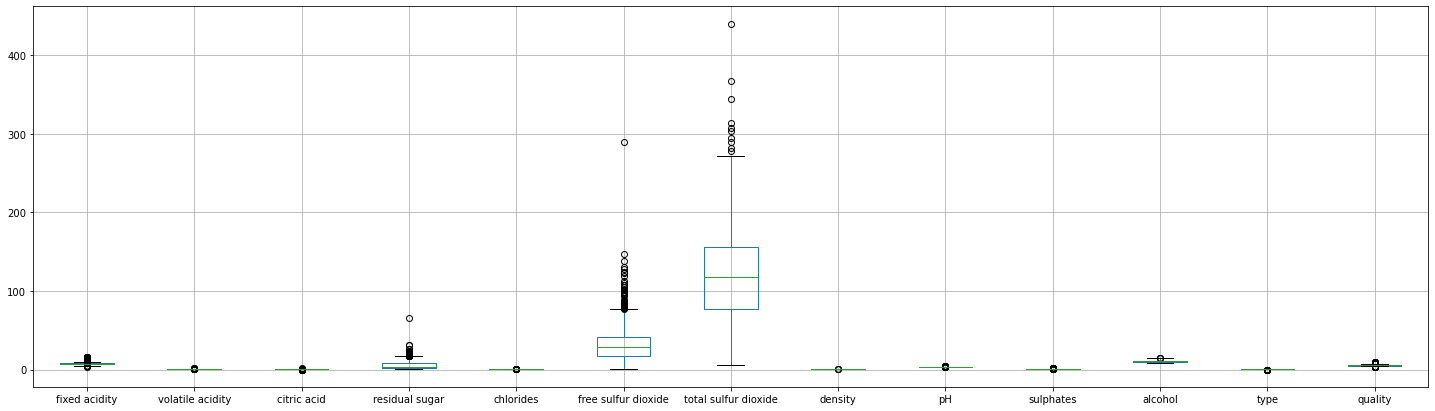

In [10]:
df.boxplot(figsize=(25,7))

Com podem veure tenim molts d'outliers, així que eliminarem els valors que estiguin per devall del percentil 0.5% i per damunt del 99.5%

Una altre manera de fer-ho és amb el següent codi que empra una fórmula basada en el rang interquartil, però trobàvem que eliminava massa files.
```python
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
```

Forma:  (6497, 13)
Forma de després d'eliminar els outliers:  (5777, 13)


<AxesSubplot:>

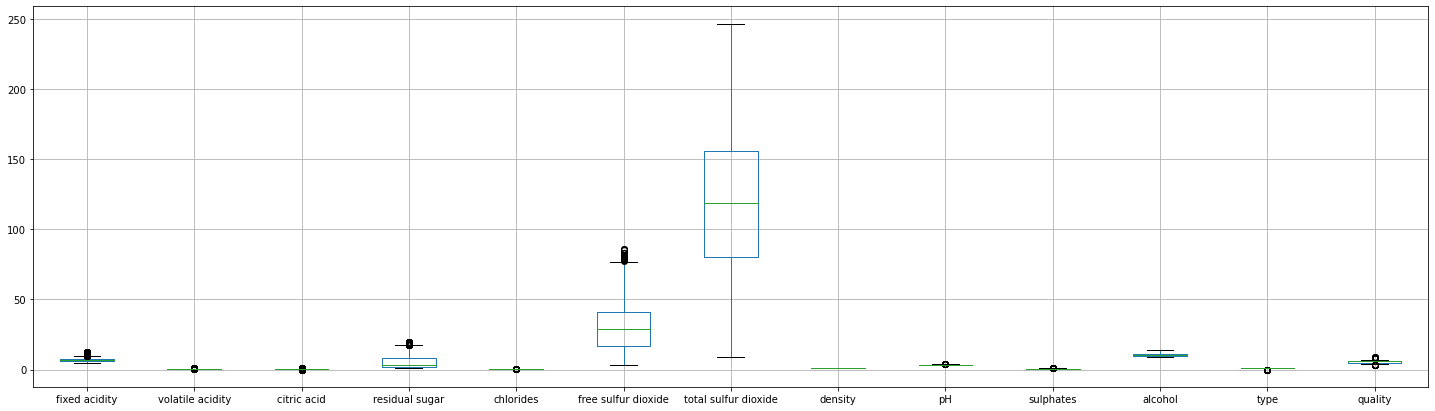

In [11]:
cols= ['fixed acidity', 'volatile acidity', 'citric acid', 
                       'residual sugar', 'chlorides', 'free sulfur dioxide',
                       'total sulfur dioxide', 'density', 'pH', 'sulphates', 
                       'alcohol']

Q01=df.quantile(0.005)
Q99=df.quantile(0.995)

print("Forma: ",df.shape)
for col in cols:
    df = df.drop(df[((df[col] < Q01[col]) | (df[col] > Q99[col]))].index)

print("Forma de després d'eliminar els outliers: ",df.shape)
df.boxplot(figsize=(25,7))


In [12]:
df['quality'].value_counts()

6    2558
5    1905
7     949
4     182
8     166
3      14
9       3
Name: quality, dtype: int64

Visualitzam les correlacions de les característiques entre elles amb una matriu de correlacions, això ho feim per saber quines característiques estan més o menys relacionades entre si

<AxesSubplot:>

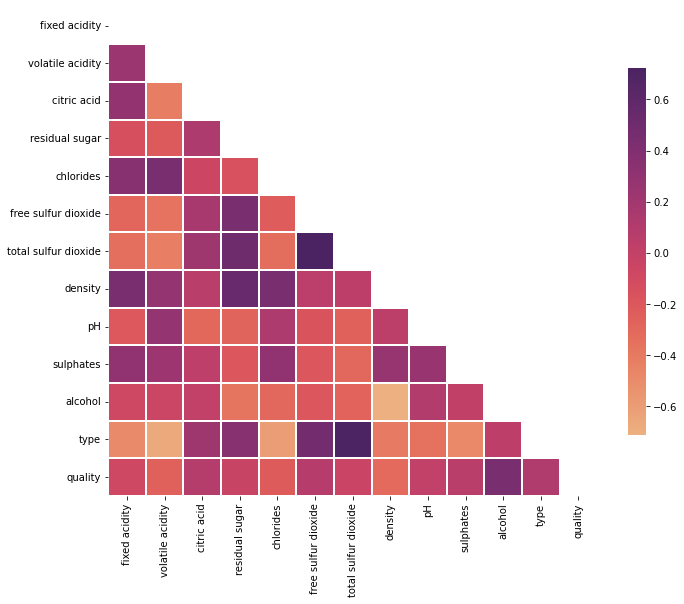

In [13]:
corr = df.corr()

# Generam una màscara pel triangle superior
mask = np.triu(np.ones_like(corr, dtype=bool))

# Preparam el gràfic de pyplot
f, ax = plt.subplots(figsize=(11, 9))

# Dibuixam el mapa de calor amb la màscara i alguns paràmetres extra per millorar el resultat visual
sns.heatmap(corr, mask=mask, cmap="flare", square=True, linewidths=.25, cbar_kws={"shrink": .75})


Graficam el valor que prenen les característiques númeriques del dataframe mitjançant un histograma

array([[<AxesSubplot:title={'center':'fixed acidity'}>,
        <AxesSubplot:title={'center':'volatile acidity'}>,
        <AxesSubplot:title={'center':'citric acid'}>],
       [<AxesSubplot:title={'center':'residual sugar'}>,
        <AxesSubplot:title={'center':'chlorides'}>,
        <AxesSubplot:title={'center':'free sulfur dioxide'}>],
       [<AxesSubplot:title={'center':'total sulfur dioxide'}>,
        <AxesSubplot:title={'center':'density'}>,
        <AxesSubplot:title={'center':'pH'}>],
       [<AxesSubplot:title={'center':'sulphates'}>,
        <AxesSubplot:title={'center':'alcohol'}>,
        <AxesSubplot:title={'center':'quality'}>]], dtype=object)

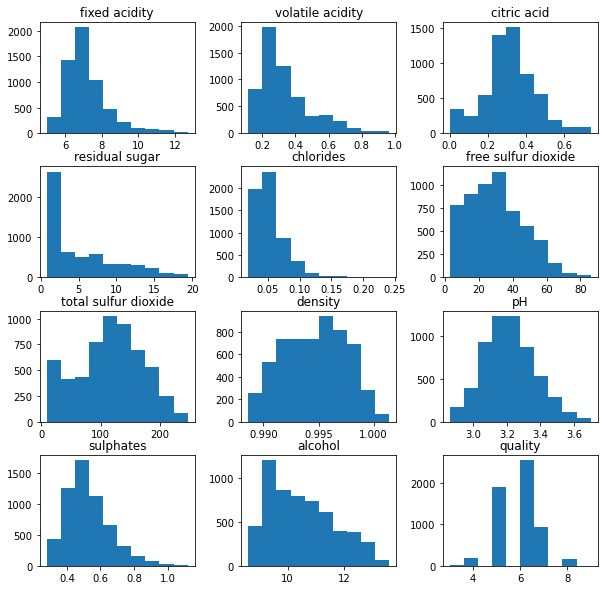

In [14]:
df.drop("type", axis=1).hist(figsize=(10,10), grid=False)

Gràfic cirular en el que podem veure la proporció de vi blanc i vermell del dataframe

1    76.458369
0    23.541631
Name: type, dtype: float64


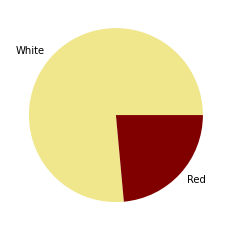

In [15]:
plt.pie(df['type'].value_counts(), labels = ["White","Red"], colors=["khaki","Maroon"])
print(df['type'].value_counts(normalize=True)*100)

## Separació del conjunt d'entrenament i el de test

Mesclam el dataframe i carregam les dades a les variables *features* (característiques) i *labels* (etiquetes). \

In [16]:
min_max_scaler = preprocessing.MinMaxScaler()
df = df.sample(frac=1) #No faria faltar mesclar-ho ja que després els classificadors faran un shuffle internament.

features, labels = load_data(df)

Per separar les dades en els conjunts d'entrenament i de test hem emprat la funció train_test_split

Hem decidit emprar un 80% entrenament i un 20% de test ja que  amb un valor més baix d'entrenament el model de regressió logistica i el del perceptró presentaven underfiting 


In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# **Classificadors**

Per a cada model imprimim el seu classification report, la precisió de training i la de testing. A més, guardam aquests dos valors dins dos dataframes externs per després poder comparar les modificacions que farem al dataframe original.

Hem decidit fer els models dins funcions per poder cridar-les des de l'apartat d'[Enginyeria de característiques/Proves](#Proves) fora haver de reescriure el codi.

In [18]:
dfTrainAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
dfTestAccuracy = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])

## Regressió Logística

Hem decidit donar-li valor al hiperparàmetre max_iters perquè amb el valor per defecte no arribava a convergir.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.71      0.60       509
           7       0.54      0.15      0.24       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 54.96645747673664
testing accuracy: 54.75778546712803

Confusion Matrix


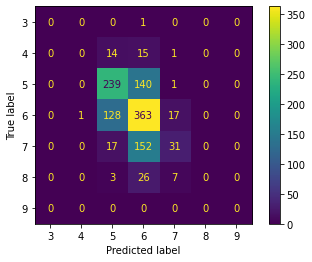

In [19]:
def RegressioLogistica(df, nom):
    #Carregam les dades del dataframe i cream les variables de Train i Test
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    #Cream una instancia del classificador
    logreg = LogisticRegression(max_iter=200)
    
    #Entrenam el classificador amb les dades de train
    logreg.fit(X_train,y_train)
    
    #Feim una predicció amb les dades de Test
    y_predict = logreg.predict(X_test)
    
    #Imprimim un classification report del test
    print("\nRegressio Logística:")
    print(classification_report(y_test, y_predict, zero_division=1))
    
    #Feim un score amb les dades de train i test per veure l'accuracy dels dos sets de dades
    training_accuracy = logreg.score(X_train,y_train)
    testing_accuracy = logreg.score(X_test,y_test)
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Regressió Logística']=training_accuracy*100
    dfTestAccuracy.at[nom,'Regressió Logística']=testing_accuracy*100 
    
    #Cream una matriu de confusió amb les dades del test
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()
    
    plt.show()

RegressioLogistica(df, "Original")

## Perceptró


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.48      0.88      0.62       380
           6       0.63      0.08      0.14       509
           7       0.32      0.09      0.13       200
           8       0.08      0.69      0.14        36

    accuracy                           0.36      1156
   macro avg       0.25      0.29      0.17      1156
weighted avg       0.50      0.36      0.29      1156

training accuracy: 35.59835533434322
testing accuracy: 35.89965397923876

Confusion Matrix


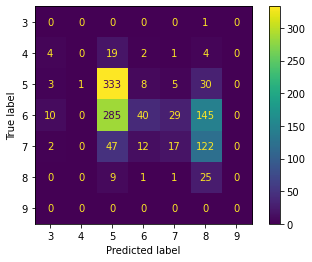

In [20]:
def Perceptro(df, nom):
    #Carregam les dades del dataframe i cream les variables de Train i Test
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    #Cream una instancia del classificador
    perceptron = Perceptron(max_iter=5000)
    
    #Entrenam el classificador amb les dades de train
    perceptron.fit(X_train,y_train)
    
    #Feim una predicció amb les dades de Test
    y_predict = perceptron.predict(X_test)
    
    #Imprimim un classification report del test
    print("\nPerceptró:")
    print(classification_report(y_test, y_predict, zero_division=1))
    
    #Feim un score amb les dades de train i test per veure l'accuracy dels dos sets de dades
    training_accuracy = perceptron.score(X_train,y_train)
    testing_accuracy = perceptron.score(X_test,y_test)
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Perceptró']=training_accuracy*100
    dfTestAccuracy.at[nom,'Perceptró']=testing_accuracy*100 
    
    #Cream una matriu de confusió amb les dades del test
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perceptron.classes_), display_labels=perceptron.classes_).plot()
    
    plt.show()

Perceptro(df, "Original")

## Random Forest

Un problema que tenim max


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.13      0.24        30
           5       0.71      0.73      0.72       380
           6       0.64      0.76      0.70       509
           7       0.75      0.55      0.63       200
           8       0.83      0.28      0.42        36

    accuracy                           0.68      1156
   macro avg       0.82      0.41      0.45      1156
weighted avg       0.70      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.16608996539793

Confusion Matrix


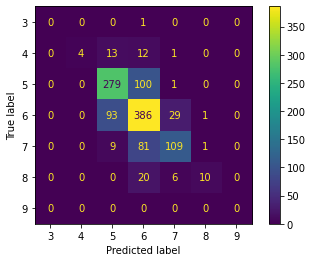

In [21]:
def RandomForest(df, nom):
    #Carregam les dades del dataframe i cream les variables de Train i Test
    features, labels = load_data(df)
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    #Cream una instancia del classificador
    rf = RandomForestClassifier()
    
    #Entrenam el classificador amb les dades de train
    rf.fit(X_train,y_train)
    
    #Feim una predicció amb les dades de Test
    y_predict = rf.predict(X_test)
    
    #Imprimim un classification report del test
    print("\nRandom Forest:")
    print(classification_report(y_test, y_predict, zero_division=1))
    
    #Feim un score amb les dades de train i test per veure l'accuracy dels dos sets de dades
    training_accuracy = rf.score(X_train,y_train)
    testing_accuracy = rf.score(X_test,y_test)
    print('training accuracy:', training_accuracy*100)    
    print('testing accuracy:', testing_accuracy*100)
    
    #Afegim les dades a dos dataframes externs per després poder fer comparacions
    dfTrainAccuracy.at[nom,'Random Forest']=training_accuracy*100
    dfTestAccuracy.at[nom,'Random Forest']=testing_accuracy*100 
    
    #Cream una matriu de confusió amb les dades del test
    print("\nConfusion Matrix")
    ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()
    
    plt.show()
           
RandomForest(df, "Original")

## Conclusions


El millor model és el Random Forest ja que té una precisió del 69.5% ... COMENTAR UN POC CADA CLASIFICADOR

# **Enginyeria de característiques**

L'enginyeria de característiques (feature engineering) és el procés de selecció, extracció, creació i transformació de les característiques d'un dataset amb l'objectiu de millorar l'eficàcia d'un model predictiu.

Per dur a terme l'enginyeria de característiques hem seguit els següents apartats: 
- **Feature importances dels models**: Ens permet saber la importància de cada característica dins cada model amb el fí d'eliminar les característiques menys importants.
- **Correlacions màximes i mínimes**: Ens permet saber quines característiques tenen major correlació entre elles. També ens permet saber quines característiques tenen menys correlació amb la qualitat del vi per després poder eliminar-les.
- **Feature Selection**: Selecció de les característiques més i menys importants. S'implementaran els següents:
   1. Sequential Feature Selection
   2. Univariate Feature Selection amb Kbest
   3. Recursive Feature Elimination

In [22]:
# Hem de necessitar un dataframe fora la qualitat, ja que els métodes que empram a continuació ens
# creen una máscara de les columnes més o menys importants de longitud columnes-1. 
# Això és degut a que el nostre dataframe inclou la qualitat però els models s'entrenen fora la qualitat
# i per tant tenen una columna menys
dfWquality=df.drop("quality", axis=1)

## Feature importances de cada model

En aquest apartat emprarem els atributs dels models de classificació desenvolupats anteriorment per elegir les dues característiques amb menys importància

### Regressió logística <a id='Regressio-Logistica'></a>

Millor característica: fixed acidity
Pitjor característica free sulfur dioxide


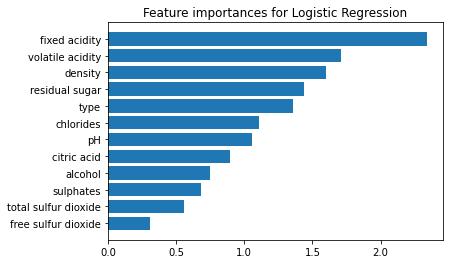

In [23]:
logreg = LogisticRegression(max_iter=5000)
logreg.fit(X_train,y_train)

logreg_odds = np.exp(logreg.coef_[0])
indices=np.argsort(logreg_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Logistic Regression")
ax.barh(range(len(logreg_odds)), logreg_odds[indices])
ax.set_yticks(range(len(logreg_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorLogReg = dfWquality.columns[indices][0]
print("Pitjor característica", pitjorLogReg)

### Perceptró <a id='Perceptro'></a>

Millor característica: fixed acidity
Pitjor característica: free sulfur dioxide


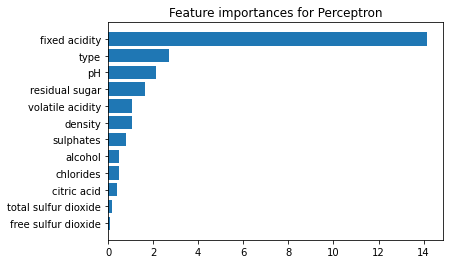

In [24]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

perceptron_odds = np.exp(perceptron.coef_[0])
indices=np.argsort(perceptron_odds)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Perceptron")
ax.barh(range(len(perceptron_odds)), perceptron_odds[indices])
ax.set_yticks(range(len(perceptron_odds)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorPerc =dfWquality.columns[indices][0]
print("Pitjor característica:", pitjorPerc)

### Random Forest <a id='Random-Forest'></a>

Millor característica: alcohol
Pitjor característica: type


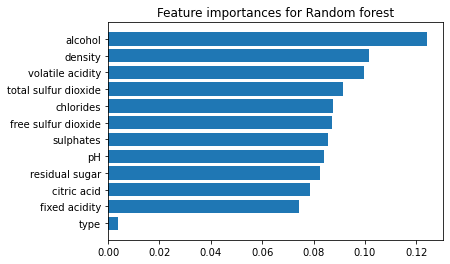

In [25]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

importancesRF = rf.feature_importances_
indices = np.argsort(importancesRF)

fig, ax = plt.subplots()
ax.set_title("Feature importances for Random forest")
ax.barh(range(len(importancesRF)), importancesRF[indices])
ax.set_yticks(range(len(importancesRF)))
_ = ax.set_yticklabels(np.array(dfWquality.columns)[indices])

print("Millor característica:", dfWquality.columns[indices][-1])
pitjorRF =dfWquality.columns[indices][0]
print("Pitjor característica:", pitjorRF)

### Comparativa entre models
| Model | Millor característica | Pitjor característica |
| ----------- | ----------- | ----------- |
| Regressió Logística | Volatile Acidity | Alcohol |
| Perceptró | Free sulfur dioxide | Sulphates |
| Random Forest | Alcohol | Type |

Ens pareix curiós que a la regressió logística la pitjor característica sigui l'alcohol però al random forest és la més important.

Els resultats poden variar depenent de l'execució, aquests valors són els obtinguts a una execució determinada.

## Correlacions màximes i mínimes <a id='Correlacions-Minimes'></a>

In [26]:
c = df.corr().abs()
s = c.unstack()
so = s.sort_values(kind="quicksort", ascending=False)

print("Majors Correlacions")
print(so[13:23]) #Les 12 primeres son autocorrelacions
print("-------------")
print("Menors correlacions amb qualitat")
print(so['quality'][10:13])
pitjorsCorrelacions=so['quality'][10:13].to_dict().keys()

Majors Correlacions
free sulfur dioxide   total sulfur dioxide    0.722973
total sulfur dioxide  free sulfur dioxide     0.722973
density               alcohol                 0.710536
alcohol               density                 0.710536
total sulfur dioxide  type                    0.708479
type                  total sulfur dioxide    0.708479
                      volatile acidity        0.665743
volatile acidity      type                    0.665743
chlorides             type                    0.606634
type                  chlorides               0.606634
dtype: float64
-------------
Menors correlacions amb qualitat
total sulfur dioxide    0.039154
residual sugar          0.034744
pH                      0.009989
dtype: float64


Les característiques que tenen la major correlació amb la qualitat són el *Free sulfur dioxide* i el *Total sulfur dioxide*, així que després provarem d'unir-les \
Les característiques que tenen la menor correlació amb la qualitat són el *pH*, *residual sugars* i *sulphates*.

## [Feature Selection](https://www.scikit-learn.org/stable/modules/feature_selection.html)

El Feature Selection és un procés de selecció de característiques que ens ajudarà a reduir la quantitat de característiques del model per deixar les més importants

### [Sequential Feature Selector](https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py) <a id='Sequential-Feature-Selector'></a>


El Sequential Feature Selector funcia amb dos procediments diferents, el Forward-SFS i el Backward-SFS. 

El Forward-SFS és un procediment greedy que troba de manera iterativa la millor característica nova per afegir al conjunt de característiques seleccionades. Inicialment començam amb zero característiques i trobam la caracteristica que maximitza una calificació de cross-validation quan un estimador es entrenat amb aquesta característica concreta. Una vegada hem afegit aquesta característica repetim es procés afegint una nova característica al conjunt de característiques seleccionades. El proces acaba quan arriba al nombre de característiques seleccionades desitjat, determinat pel paràmetre n_features_to_select.

El Backward-SFS segueix la mateixa idea, però funciona en la direcció oposada: en lloc de començar sense cap característica i afegir-ne, començam amb totes les característiques i eliminam característiques del conjunt. El paràmetre direction controla si s'utilitza el Forward-SFS o el Backward-SFS.

In [27]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [28]:
sfs_forward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="forward"
).fit(X_train, y_train)


sfs_backward = SequentialFeatureSelector(
    ridge, n_features_to_select=10, direction="backward"
).fit(X_train, y_train)

pitjorSFSF=dfWquality.columns.difference(feature_names[sfs_forward.get_support()]).tolist()
pitjorSFSB=dfWquality.columns.difference(feature_names[sfs_backward.get_support()]).tolist()
print(type(pitjorSFSB))
print(
    "Features selected by forward sequential selection: "
    f"{feature_names[sfs_forward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{pitjorSFSF}\n"
)

print(
    "Features selected by backward sequential selection: "
    f"{feature_names[sfs_backward.get_support()]}"
    "\nFeatures not selected by forward sequential selection: "
    f"{pitjorSFSB}"
)

<class 'list'>
Features selected by forward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: ['chlorides', 'citric acid']

Features selected by backward sequential selection: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Features not selected by forward sequential selection: ['chlorides', 'citric acid']


### [Univariate Feature selection with Kbest](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.GenericUnivariateSelect.html#sklearn.feature_selection.GenericUnivariateSelect) <a id='Univariate-feature-selection'></a> 


El Univariate feature selection funcioan seleccionant les millors característiques basat en proves estadístiques univariades.

Nosaltres hem emprat el SelectKBest, que elimina totes les característiques excepte les k millors. No sabem molt bé com funciona internament

In [29]:
mask = SelectKBest(f_regression, k=10).fit(X_train, y_train).get_support()

best_features = dfWquality.columns[mask].tolist()
pitjorsUFS = dfWquality.columns.difference(best_features).tolist()

print("Millors característiques: ", best_features)
print("Pitjors característiques: ", pitjorsUFS)

Millors característiques:  ['fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'sulphates', 'alcohol', 'type']
Pitjors característiques:  ['pH', 'residual sugar']


### [Recursive Feature Elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE) <a id='Recursive-feature-elimination'></a> 


El Recursive Feature Elimination du a terme una classificació de característiques mitjançant l'eliminació recursiva de característiques.

Donat un estimador extern que assigna pesos a les característiques, l'objectiu de l'eliminació de característiques recursives (RFE) és seleccionar característiques considerant recursivament conjunts de característiques cada cop més petits. En primer lloc, l'estimador s'entrena en el conjunt inicial de característiques i la importància de cada característiques s'obté a través de qualsevol atribut . Aleshores, les característiques menys importants s'eliminen del conjunt actual de funcions. Aquest procediment es repeteix recursivament al conjunt podat fins que s'arriba al nombre desitjat de funcions per seleccionar.

In [30]:
feature_names = np.array(dfWquality.columns)
ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)

In [31]:
rfe_selector = RFE(ridge, n_features_to_select=10).fit(X_train, y_train)

pitjorsRFE=dfWquality.columns.difference(feature_names[rfe_selector.get_support()]).tolist()
print(
    "Característiques triades pel recursive feature elimination: "
    f"{feature_names[rfe_selector.get_support()]}"
    "\nCaracterístiques no triades pel recursive feature elimination: "
    f"{pitjorsRFE}\n"
)

Característiques triades pel recursive feature elimination: ['fixed acidity' 'volatile acidity' 'residual sugar' 'free sulfur dioxide'
 'total sulfur dioxide' 'density' 'pH' 'sulphates' 'alcohol' 'type']
Característiques no triades pel recursive feature elimination: ['chlorides', 'citric acid']



### 
| Tipus | 1ra Pitjor Caract. | 2na Pitjor Caract.|
| ----------- | ----------- | ----------- |
| Sequential Feature Selection - Forward| Free sulfur dioxide | Total sulfur dioxide |
| Sequential Feature Selection - backward| Chloride | Citric Acid |
| Univariate Feature Selection | pH | Sulphates |
| Recursive Feature Elimination | Citric Acid | Type |

## 
Una vegada hem fet aquest anàlisi de les dades per arribar a la conclusió de quines eliminar o unir, podem donar lloc al següent pas, on farem modificacions al dataframe original i crearem 3 models per a cada nou dataframe. Una vegada fet això compararem les precisions de tots els models per determinar el model amb major precicisió <a id='Proves'></a>

## Eliminam característiques

En aquest subapartat eliminarem les característiques que, segons els diferents procediments fets anteriorment, tenen menor importància

In [32]:
dfComentaris = pd.DataFrame(columns=['Comentaris'])

### Característica de menor importància de la Regressió Logística

Com s'ha observat [aquí](#Regressio-Logistica), el Feature Selection de la Regressió Logística indica que és la característica amb menys importància.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.62      0.61       380
           6       0.52      0.72      0.60       509
           7       0.59      0.16      0.25       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.62      0.25      0.24      1156
weighted avg       0.56      0.55      0.51      1156

training accuracy: 54.66349275048691
testing accuracy: 54.67128027681662

Confusion Matrix


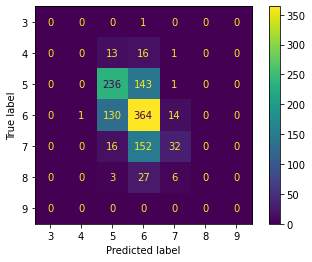


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.66      0.48      0.55       380
           6       0.49      0.60      0.54       509
           7       0.30      0.09      0.13       200
           8       0.06      0.33      0.10        36

    accuracy                           0.44      1156
   macro avg       0.59      0.25      0.22      1156
weighted avg       0.52      0.44      0.45      1156

training accuracy: 45.46634927504869
testing accuracy: 44.37716262975779

Confusion Matrix


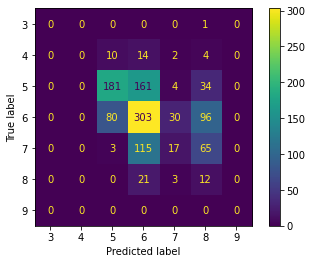


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.71      0.17      0.27        30
           5       0.70      0.73      0.72       380
           6       0.63      0.74      0.68       509
           7       0.73      0.52      0.61       200
           8       0.83      0.28      0.42        36

    accuracy                           0.67      1156
   macro avg       0.77      0.41      0.45      1156
weighted avg       0.68      0.67      0.66      1156

training accuracy: 100.0
testing accuracy: 66.95501730103807

Confusion Matrix


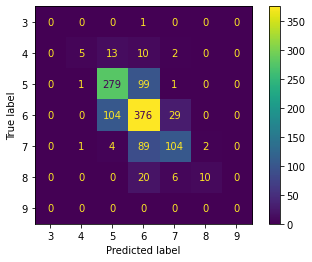

In [33]:
df_menor_LogReg = df.drop(pitjorLogReg,axis=1)

RegressioLogistica(df_menor_LogReg, "menor imp. LogReg")
Perceptro(df_menor_LogReg, "menor imp. LogReg")
RandomForest(df_menor_LogReg, "menor imp. LogReg")

dfComentaris.at["menor imp. LogReg",'Comentaris']=pitjorLogReg

### Característica de menor importància del Perceptró

Com s'ha observat [aquí](#Perceptro), el Feature Selection del Perceptró indica que és la característica amb menys importància.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.62      0.61       380
           6       0.52      0.72      0.60       509
           7       0.59      0.16      0.25       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.62      0.25      0.24      1156
weighted avg       0.56      0.55      0.51      1156

training accuracy: 54.66349275048691
testing accuracy: 54.67128027681662

Confusion Matrix


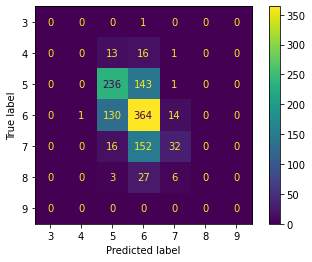


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.66      0.48      0.55       380
           6       0.49      0.60      0.54       509
           7       0.30      0.09      0.13       200
           8       0.06      0.33      0.10        36

    accuracy                           0.44      1156
   macro avg       0.59      0.25      0.22      1156
weighted avg       0.52      0.44      0.45      1156

training accuracy: 45.46634927504869
testing accuracy: 44.37716262975779

Confusion Matrix


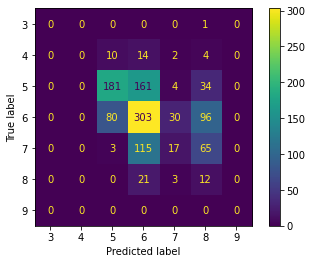


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.13      0.24        30
           5       0.71      0.74      0.72       380
           6       0.64      0.75      0.69       509
           7       0.70      0.52      0.59       200
           8       0.83      0.28      0.42        36

    accuracy                           0.67      1156
   macro avg       0.81      0.40      0.44      1156
weighted avg       0.69      0.67      0.66      1156

training accuracy: 100.0
testing accuracy: 67.30103806228374

Confusion Matrix


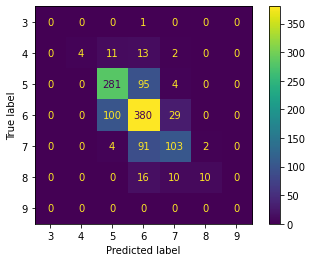

In [34]:
df_menor_Perc = df.drop(pitjorPerc,axis=1)

RegressioLogistica(df_menor_Perc, "menor imp. Perc")
Perceptro(df_menor_Perc, "menor imp. Perc")
RandomForest(df_menor_Perc, "menor imp. Perc")

dfComentaris.at["menor imp. Perc",'Comentaris']=pitjorPerc

### Característica de menor importància del Random Forest

Com s'ha observat [aquí](#Random-Forest), el Feature Selection del Random Forest indica que és la característica amb menys importància.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.72      0.60       509
           7       0.56      0.17      0.25       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.78      0.25      0.25      1156
weighted avg       0.58      0.55      0.51      1156

training accuracy: 54.793334776022505
testing accuracy: 55.017301038062286

Confusion Matrix


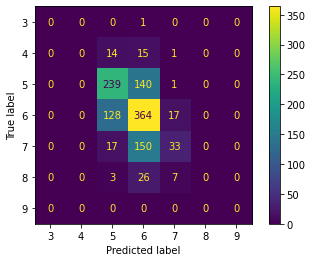


Perceptró:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.68      0.17      0.27       380
           6       0.46      0.85      0.60       509
           7       0.27      0.14      0.19       200
           8       0.50      0.03      0.05        36

    accuracy                           0.46      1156
   macro avg       0.49      0.20      0.19      1156
weighted avg       0.52      0.46      0.39      1156

training accuracy: 44.73057779701363
testing accuracy: 45.761245674740486

Confusion Matrix


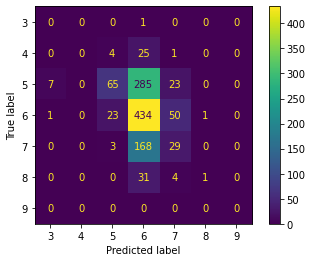


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.13      0.23        30
           5       0.71      0.74      0.73       380
           6       0.64      0.76      0.70       509
           7       0.75      0.51      0.60       200
           8       0.92      0.31      0.46        36

    accuracy                           0.68      1156
   macro avg       0.80      0.41      0.45      1156
weighted avg       0.70      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.16608996539793

Confusion Matrix


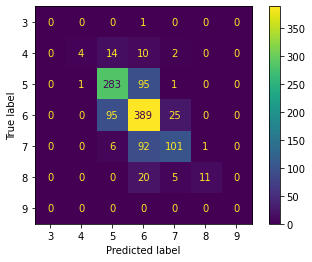

In [35]:
df_menor_RF = df.drop(pitjorRF,axis=1)

RegressioLogistica(df_menor_RF, "menor imp. RF")
Perceptro(df_menor_RF, "menor imp. RF")
RandomForest(df_menor_RF, "menor imp. RF")

dfComentaris.at["menor imp. RF",'Comentaris']=pitjorRF

### Característica amb les pitjors correlacions amb la qualitat

Com s'ha observat [aquí](#Correlacions-Minimes), són les tres característiques menys correlacionades amb la qualitat.


Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.62      0.60       380
           6       0.51      0.71      0.59       509
           7       0.48      0.12      0.19       200
           8       1.00      0.00      0.00        36

    accuracy                           0.53      1156
   macro avg       0.60      0.24      0.23      1156
weighted avg       0.53      0.53      0.49      1156

training accuracy: 54.10084397316598
testing accuracy: 53.37370242214533

Confusion Matrix


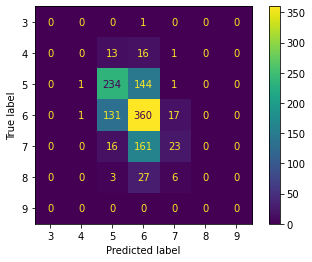


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.10      0.03      0.05        30
           5       0.64      0.48      0.55       380
           6       0.49      0.35      0.41       509
           7       0.32      0.79      0.46       200
           8       1.00      0.00      0.00        36

    accuracy                           0.45      1156
   macro avg       0.59      0.28      0.24      1156
weighted avg       0.52      0.45      0.44      1156

training accuracy: 45.29322657433456
testing accuracy: 45.15570934256055

Confusion Matrix


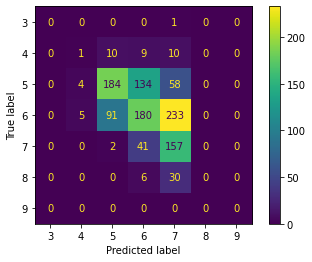


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.60      0.10      0.17        30
           5       0.69      0.72      0.70       380
           6       0.62      0.73      0.67       509
           7       0.70      0.51      0.59       200
           8       0.75      0.25      0.38        36

    accuracy                           0.65      1156
   macro avg       0.73      0.38      0.42      1156
weighted avg       0.66      0.65      0.64      1156

training accuracy: 100.0
testing accuracy: 65.48442906574394

Confusion Matrix


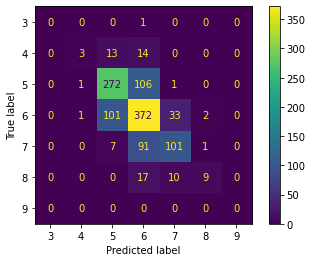

In [36]:
df_Correlacions = df.drop(pitjorsCorrelacions,axis=1)

RegressioLogistica(df_Correlacions, "Pitjors carac. Correlacions")
Perceptro(df_Correlacions, "Pitjors carac. Correlacions")
RandomForest(df_Correlacions, "Pitjors carac. Correlacions")

dfComentaris.at["Pitjors carac. Correlacions",'Comentaris']=pitjorsCorrelacions

### Característica amb les pitjors característiques del Forward Feature Selection

Com s'ha observat [aquí](#Sequential-Feature-Selector), ja que el Forward Feature Selection indica que són les dues pitjors característiques.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.61      0.64      0.62       380
           6       0.53      0.72      0.61       509
           7       0.53      0.15      0.23       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.85371131789656
testing accuracy: 55.36332179930796

Confusion Matrix


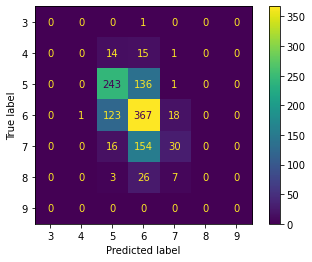


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.45      0.91      0.60       380
           6       1.00      0.00      0.00       509
           7       0.37      0.65      0.47       200
           8       0.26      0.19      0.22        36

    accuracy                           0.42      1156
   macro avg       0.68      0.29      0.21      1156
weighted avg       0.68      0.42      0.28      1156

training accuracy: 40.121185890499895
testing accuracy: 41.608996539792386

Confusion Matrix


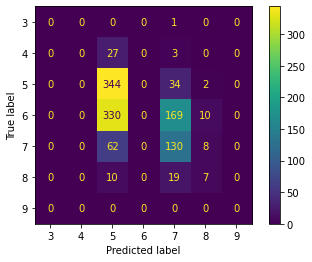


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.57      0.13      0.22        30
           5       0.71      0.76      0.73       380
           6       0.67      0.76      0.71       509
           7       0.73      0.56      0.63       200
           8       0.83      0.28      0.42        36

    accuracy                           0.69      1156
   macro avg       0.75      0.41      0.45      1156
weighted avg       0.70      0.69      0.68      1156

training accuracy: 100.0
testing accuracy: 69.29065743944636

Confusion Matrix


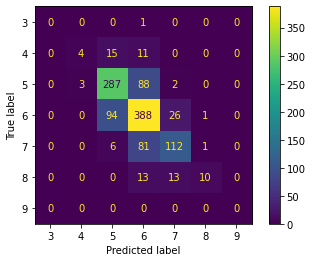

In [37]:
df_SFSF = df.drop(pitjorSFSF,axis=1)

RegressioLogistica(df_SFSF, "Pitjors carac. SFSF")
Perceptro(df_SFSF, "Pitjors carac. SFSF")
RandomForest(df_SFSF, "Pitjors carac. SFSF")

dfComentaris.at["Pitjors carac. SFSF",'Comentaris']=pitjorSFSF

### Pitjors característiques Backward Feature Selection

Com s'ha observat [aquí](#Sequential-Feature-Selector), el Backward Feature Selection indica que són les dues pitjors característiques.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.61      0.64      0.62       380
           6       0.53      0.72      0.61       509
           7       0.53      0.15      0.23       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.85371131789656
testing accuracy: 55.36332179930796

Confusion Matrix


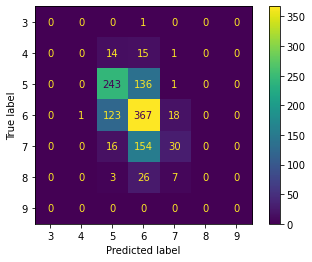


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.45      0.91      0.60       380
           6       1.00      0.00      0.00       509
           7       0.37      0.65      0.47       200
           8       0.26      0.19      0.22        36

    accuracy                           0.42      1156
   macro avg       0.68      0.29      0.21      1156
weighted avg       0.68      0.42      0.28      1156

training accuracy: 40.121185890499895
testing accuracy: 41.608996539792386

Confusion Matrix


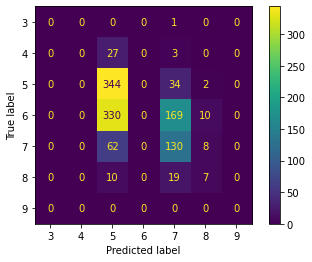


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.13      0.23        30
           5       0.71      0.74      0.73       380
           6       0.65      0.75      0.69       509
           7       0.72      0.54      0.62       200
           8       0.82      0.25      0.38        36

    accuracy                           0.68      1156
   macro avg       0.78      0.40      0.44      1156
weighted avg       0.69      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 67.99307958477509

Confusion Matrix


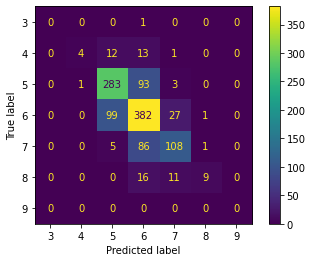

In [38]:
df_SFSB = df.drop(pitjorSFSB,axis=1)

RegressioLogistica(df_SFSB, "Pitjors carac. SFSB")
Perceptro(df_SFSB, "Pitjors carac. SFSB")
RandomForest(df_SFSB, "Pitjors carac. SFSB")

dfComentaris.at["Pitjors carac. SFSB",'Comentaris']=pitjorSFSB

### Pitjors característiques Univariate Feature Selection

Com s'ha observat [aquí](#Univariate-feature-selection), el SelectKBest indica que són les dues pitjors característiques.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.65      0.62       380
           6       0.51      0.71      0.60       509
           7       0.42      0.09      0.15       200
           8       1.00      0.00      0.00        36

    accuracy                           0.54      1156
   macro avg       0.59      0.24      0.23      1156
weighted avg       0.53      0.54      0.49      1156

training accuracy: 54.49037004977277
testing accuracy: 54.06574394463668

Confusion Matrix


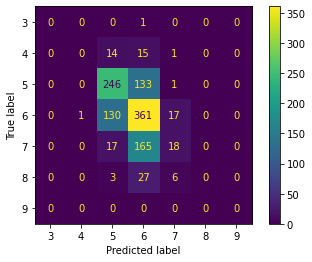


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.62      0.45      0.52       380
           6       0.48      0.83      0.61       509
           7       0.00      0.00      0.00       200
           8       1.00      0.00      0.00        36

    accuracy                           0.51      1156
   macro avg       0.68      0.21      0.19      1156
weighted avg       0.47      0.51      0.44      1156

training accuracy: 51.78532785111448
testing accuracy: 51.21107266435986

Confusion Matrix


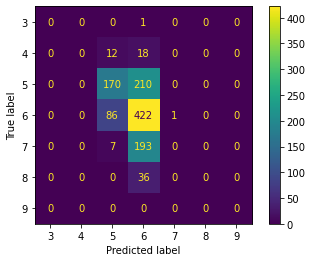


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.13      0.23        30
           5       0.70      0.75      0.73       380
           6       0.65      0.75      0.70       509
           7       0.75      0.54      0.62       200
           8       0.82      0.25      0.38        36

    accuracy                           0.68      1156
   macro avg       0.79      0.40      0.44      1156
weighted avg       0.69      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.25259515570934

Confusion Matrix


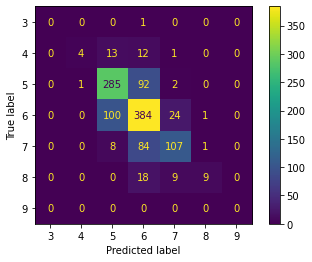

In [39]:
df_UFS = df.drop(pitjorsUFS,axis=1)

RegressioLogistica(df_UFS, "Pitjors carac. UFS")
Perceptro(df_UFS, "Pitjors carac. UFS")
RandomForest(df_UFS, "Pitjors carac. UFS")

dfComentaris.at["Pitjors carac. UFS",'Comentaris']=pitjorsUFS

### Pitjors característiques Recursive Feature Selection

Com hem vist [aquí](#Recursive-feature-elimination), el Recursive Feature Elimination indica que són les dues pitjors característiques.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.61      0.64      0.62       380
           6       0.53      0.72      0.61       509
           7       0.53      0.15      0.23       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.85371131789656
testing accuracy: 55.36332179930796

Confusion Matrix


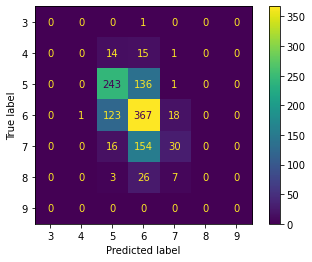


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.45      0.91      0.60       380
           6       1.00      0.00      0.00       509
           7       0.37      0.65      0.47       200
           8       0.26      0.19      0.22        36

    accuracy                           0.42      1156
   macro avg       0.68      0.29      0.21      1156
weighted avg       0.68      0.42      0.28      1156

training accuracy: 40.121185890499895
testing accuracy: 41.608996539792386

Confusion Matrix


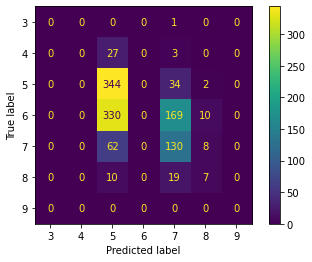


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.75      0.10      0.18        30
           5       0.71      0.77      0.74       380
           6       0.66      0.75      0.70       509
           7       0.73      0.54      0.62       200
           8       0.92      0.31      0.46        36

    accuracy                           0.69      1156
   macro avg       0.80      0.41      0.45      1156
weighted avg       0.70      0.69      0.68      1156

training accuracy: 100.0
testing accuracy: 69.03114186851211

Confusion Matrix


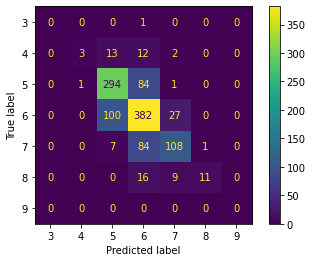

In [40]:
df_RFE = df.drop(pitjorsRFE,axis=1)

RegressioLogistica(df_RFE, "Pitjors carac. RFE")
Perceptro(df_RFE, "Pitjors carac. RFE")
RandomForest(df_RFE, "Pitjors carac. RFE")

dfComentaris.at["Pitjors carac. RFE",'Comentaris']=pitjorsRFE

## Cream característiques

Per crear les característiques noves hem emprat l'eina MathematicalCombinator que ens permet crear noves columnes/variables a partir d'operacions i combinacions d'altres. Per decidir quines característiques creavem o no ens hem basat en la correlació entre característiques i la nostra intuició.

### Àcids totals

Com tenim l'acidesa fixada i la volàtil, provarem de crear una de nova característica que sigui la total

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.71      0.60       509
           7       0.55      0.16      0.25       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 54.92317680155811
testing accuracy: 54.844290657439444

Confusion Matrix


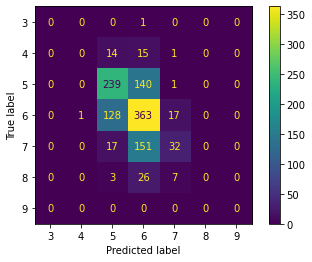


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.71      0.11      0.19       380
           6       0.45      0.97      0.62       509
           7       0.50      0.01      0.01       200
           8       1.00      0.00      0.00        36

    accuracy                           0.46      1156
   macro avg       0.78      0.18      0.14      1156
weighted avg       0.58      0.46      0.34      1156

training accuracy: 46.44016446656568
testing accuracy: 46.45328719723184

Confusion Matrix


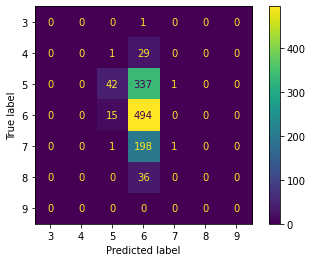


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.13      0.24        30
           5       0.70      0.74      0.72       380
           6       0.64      0.76      0.69       509
           7       0.73      0.51      0.60       200
           8       0.82      0.25      0.38        36

    accuracy                           0.67      1156
   macro avg       0.82      0.40      0.44      1156
weighted avg       0.69      0.67      0.66      1156

training accuracy: 100.0
testing accuracy: 67.47404844290658

Confusion Matrix


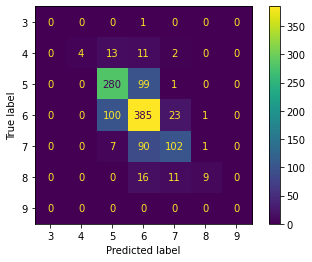

In [41]:
combinator_Acid_Tot = MathematicalCombination(
    variables_to_combine=['fixed acidity', 'volatile acidity'],
    math_operations = ['sum'],
    new_variables_names = ['total_acidity']
)

df_Acid_Tot = combinator_Acid_Tot.fit_transform(df)

RegressioLogistica(df_Acid_Tot, "Acid Totals")
Perceptro(df_Acid_Tot, "Acid Totals")
RandomForest(df_Acid_Tot, "Acid Totals")

### Percentatge d'àcid cítric respecte de l'acidesa fixada

L'àcid cítric està inclòs dins l'acidesa fixada, així que crearem una nova característica que sigui el percentatge de àcid cítric respecte la fixada.

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.63      0.61       380
           6       0.52      0.72      0.60       509
           7       0.54      0.15      0.24       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.22614152780784
testing accuracy: 54.75778546712803

Confusion Matrix


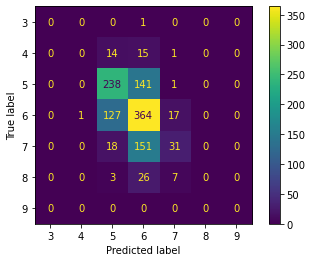


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.46      0.90      0.61       380
           6       0.53      0.25      0.34       509
           7       0.41      0.38      0.39       200
           8       1.00      0.00      0.00        36

    accuracy                           0.47      1156
   macro avg       0.73      0.25      0.22      1156
weighted avg       0.52      0.47      0.42      1156

training accuracy: 46.07227872754815
testing accuracy: 46.97231833910035

Confusion Matrix


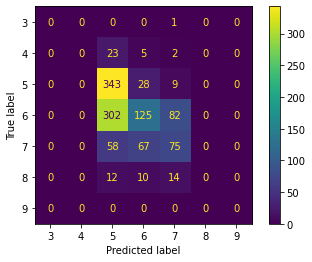


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.10      0.18        30
           5       0.70      0.73      0.71       380
           6       0.63      0.75      0.69       509
           7       0.74      0.52      0.61       200
           8       0.91      0.28      0.43        36

    accuracy                           0.67      1156
   macro avg       0.83      0.40      0.44      1156
weighted avg       0.69      0.67      0.66      1156

training accuracy: 100.0
testing accuracy: 67.21453287197232

Confusion Matrix


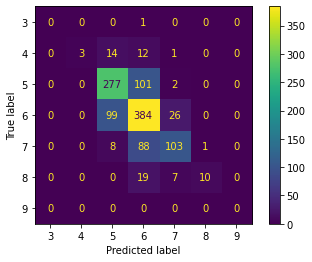

In [42]:
combinator_PercAC = CombineWithReferenceFeature(
    variables_to_combine=['citric acid'],
    reference_variables=['fixed acidity'],
    operations=['div'],   
    new_variables_names=['percentage_citric_acid'])

df_PercAC = combinator_PercAC.fit_transform(df)

RegressioLogistica(df_PercAC, "Perc. acid citric")
Perceptro(df_PercAC, "Perc. acid citric")
RandomForest(df_PercAC, "Perc. acid citric")

### Minerals totals

Com tenim els sulfats i els clorurs, que ambdos son minerals cream una nova caraterística anomenada minerals totals que representi la seva suma

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.71      0.60       509
           7       0.54      0.15      0.24       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.0530188270937
testing accuracy: 54.67128027681662

Confusion Matrix


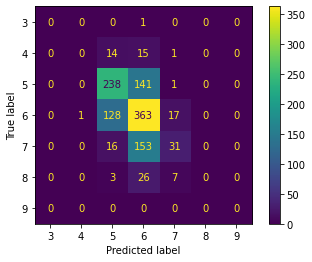


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.75      0.12      0.21       380
           6       0.46      0.98      0.62       509
           7       1.00      0.00      0.00       200
           8       0.00      0.00      0.00        36

    accuracy                           0.47      1156
   macro avg       0.53      0.18      0.14      1156
weighted avg       0.62      0.47      0.34      1156

training accuracy: 46.09391906513742
testing accuracy: 46.97231833910035

Confusion Matrix


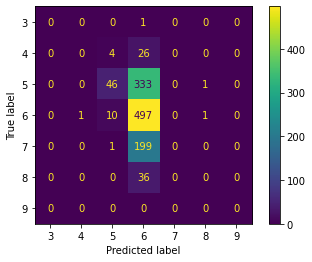


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.13      0.24        30
           5       0.71      0.74      0.73       380
           6       0.64      0.76      0.69       509
           7       0.73      0.53      0.61       200
           8       0.91      0.28      0.43        36

    accuracy                           0.68      1156
   macro avg       0.83      0.41      0.45      1156
weighted avg       0.70      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.07958477508652

Confusion Matrix


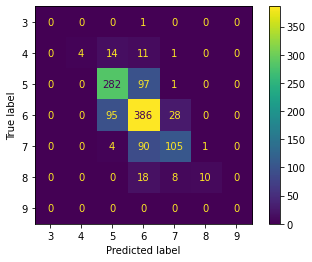

In [43]:
combinator_Minerals_Totals = MathematicalCombination(
    variables_to_combine=['chlorides', 'sulphates'],
    math_operations = ['sum'],
    new_variables_names = ['total_minerals']
)

df_Minerals_Totals = combinator_Minerals_Totals.fit_transform(df)

RegressioLogistica(df_Minerals_Totals, "Minerals totals")
Perceptro(df_Minerals_Totals, "Minerals totals")
RandomForest(df_Minerals_Totals, "Minerals totals")

### Percentatge de diòxid de sofre lliure

El SO2 lliure i el SO2 total son les dues característiques més relacionades així que cream una nova respecte a aquestes dues que sigui el percentatge de SO2 lliure respecte al total

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.71      0.60       509
           7       0.55      0.17      0.26       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.25      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.031378489504434
testing accuracy: 54.93079584775087

Confusion Matrix


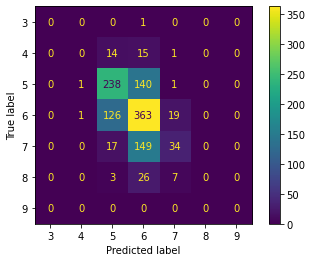


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.08      0.17      0.11        30
           5       0.57      0.66      0.61       380
           6       0.62      0.10      0.17       509
           7       0.32      0.06      0.09       200
           8       0.06      0.83      0.10        36

    accuracy                           0.30      1156
   macro avg       0.44      0.30      0.18      1156
weighted avg       0.52      0.30      0.30      1156

training accuracy: 29.668902834884225
testing accuracy: 29.93079584775086

Confusion Matrix


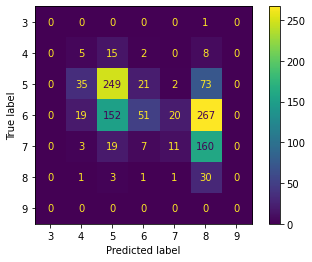


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.13      0.23        30
           5       0.73      0.75      0.74       380
           6       0.64      0.76      0.70       509
           7       0.71      0.52      0.60       200
           8       0.91      0.28      0.43        36

    accuracy                           0.68      1156
   macro avg       0.80      0.41      0.45      1156
weighted avg       0.70      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.42560553633218

Confusion Matrix


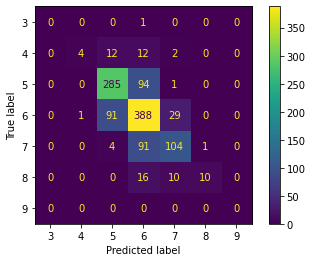

In [44]:
combinator_PercSO2 = CombineWithReferenceFeature(
    variables_to_combine=['free sulfur dioxide'],
    reference_variables=['total sulfur dioxide'],
    operations=['div'],   
    new_variables_names=['percentage_free_sulfur'])

df_PercSO2 = combinator_PercSO2.fit_transform(df)

RegressioLogistica(df_PercSO2, "Perc. SO2 lliure")
Perceptro(df_PercSO2, "Perc. SO2 lliure")
RandomForest(df_PercSO2, "Perc. SO2 lliure")

### Diòxid de sofre no lliure

Parescut a l'anterior apartat, aquí cream una nova característica que és el SO2 no lliure

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.63      0.61       380
           6       0.52      0.71      0.60       509
           7       0.55      0.16      0.25       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 54.90153646396884
testing accuracy: 54.58477508650519

Confusion Matrix


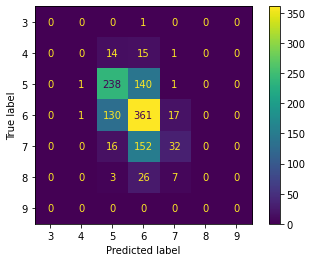


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.81      0.09      0.16       380
           6       0.45      0.98      0.62       509
           7       1.00      0.00      0.00       200
           8       1.00      0.00      0.00        36

    accuracy                           0.46      1156
   macro avg       0.71      0.18      0.13      1156
weighted avg       0.67      0.46      0.32      1156

training accuracy: 45.68275265094135
testing accuracy: 46.280276816608996

Confusion Matrix


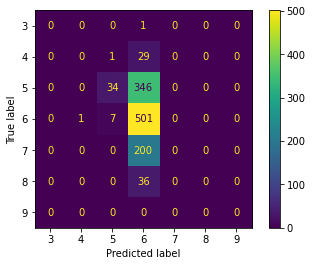


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.17      0.29        30
           5       0.72      0.75      0.73       380
           6       0.65      0.76      0.70       509
           7       0.76      0.54      0.63       200
           8       0.77      0.28      0.41        36

    accuracy                           0.69      1156
   macro avg       0.82      0.42      0.46      1156
weighted avg       0.70      0.69      0.68      1156

training accuracy: 100.0
testing accuracy: 69.03114186851211

Confusion Matrix


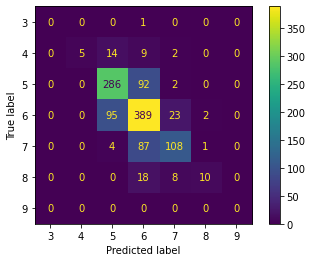

In [45]:
combinator_No_FreeSO2 = CombineWithReferenceFeature(
    variables_to_combine=['total sulfur dioxide'],
    reference_variables=['free sulfur dioxide'],
    operations=['sub'],
    new_variables_names=['non_free_sulfur_dioxide']
)

df_No_FreeSO2 = combinator_No_FreeSO2.fit_transform(df)

RegressioLogistica(df_No_FreeSO2, "S02 no lliure")
Perceptro(df_No_FreeSO2, "S02 no lliure")
RandomForest(df_No_FreeSO2, "S02 no lliure")


### Unim totes les creacions

Juntarem totes les característiques creades en un sol dataframe

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Regressio Logística:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.62      0.61       380
           6       0.52      0.72      0.60       509
           7       0.56      0.17      0.26       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.25      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 55.355983553343435
testing accuracy: 54.93079584775087

Confusion Matrix


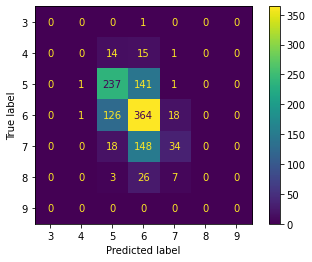


Perceptró:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.67      0.36      0.47       380
           6       0.48      0.89      0.62       509
           7       0.33      0.01      0.01       200
           8       1.00      0.00      0.00        36

    accuracy                           0.51      1156
   macro avg       0.75      0.21      0.18      1156
weighted avg       0.55      0.51      0.43      1156

training accuracy: 51.39580177450769
testing accuracy: 51.21107266435986

Confusion Matrix


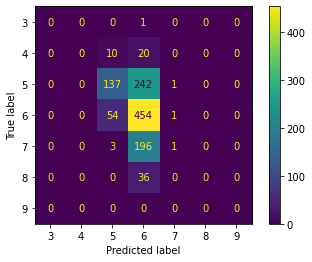


Random Forest:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.80      0.13      0.23        30
           5       0.70      0.73      0.72       380
           6       0.64      0.76      0.69       509
           7       0.76      0.53      0.63       200
           8       0.85      0.31      0.45        36

    accuracy                           0.68      1156
   macro avg       0.79      0.41      0.45      1156
weighted avg       0.69      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 67.82006920415225

Confusion Matrix


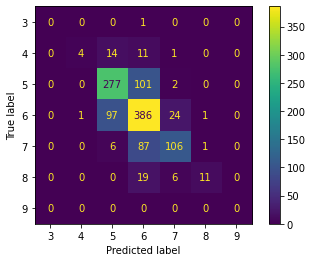

In [46]:
df_Unió = combinator_Acid_Tot.fit_transform(df)
df_Unió = combinator_Minerals_Totals.fit_transform(df_Unió)
df_Unió = combinator_PercAC.fit_transform(df_Unió)
df_Unió = combinator_No_FreeSO2.fit_transform(df_Unió)
df_Unió = combinator_PercSO2.fit_transform(df_Unió)

RegressioLogistica(df_Unió, "Totes creacions")
Perceptro(df_Unió, "Totes creacions")
RandomForest(df_Unió, "Totes creacions")

## Comparam les precisions i conclusions

En aquest apartat feim un print de les "accuracies" de tots les versions del dataframes per poder comparar-les. També calcularem la diferència de cada variació amb l'original i la difern

In [47]:
print("Training accuracy for each model and each dataframe\n", dfTrainAccuracy)
print("\nTesting accuracy for each model and each dataframe\n", dfTestAccuracy)
print("\n\nLes features eliminades han sigut:\n", dfComentaris)

Training accuracy for each model and each dataframe
                             Regressió Logística  Perceptró Random Forest
Original                              54.966457  35.598355         100.0
menor imp. LogReg                     54.663493  45.466349         100.0
menor imp. Perc                       54.663493  45.466349         100.0
menor imp. RF                         54.793335  44.730578         100.0
Pitjors carac. Correlacions           54.100844  45.293227         100.0
Pitjors carac. SFSF                   55.853711  40.121186         100.0
Pitjors carac. SFSB                   55.853711  40.121186         100.0
Pitjors carac. UFS                     54.49037  51.785328         100.0
Pitjors carac. RFE                    55.853711  40.121186         100.0
Acid Totals                           54.923177  46.440164         100.0
Perc. acid citric                     55.226142  46.072279         100.0
Minerals totals                       55.053019  46.093919         100.

In [48]:
dfDiffs = pd.DataFrame(columns=['Regressió Logística','Perceptró','Random Forest'])
for index, row in dfTestAccuracy.iterrows():
    dfDiffs.at[row.name]=row-dfTestAccuracy.loc['Original']
dfDiffs['Media'] = dfDiffs.mean(axis=1)
print(dfDiffs)

                            Regressió Logística  Perceptró Random Forest  \
Original                                    0.0        0.0           0.0   
menor imp. LogReg                     -0.086505   8.477509     -1.211073   
menor imp. Perc                       -0.086505   8.477509     -0.865052   
menor imp. RF                          0.259516   9.861592           0.0   
Pitjors carac. Correlacions           -1.384083   9.256055     -2.681661   
Pitjors carac. SFSF                    0.605536   5.709343      1.124567   
Pitjors carac. SFSB                    0.605536   5.709343      -0.17301   
Pitjors carac. UFS                    -0.692042  15.311419      0.086505   
Pitjors carac. RFE                     0.605536   5.709343      0.865052   
Acid Totals                            0.086505  10.553633     -0.692042   
Perc. acid citric                           0.0  11.072664     -0.951557   
Minerals totals                       -0.086505  11.072664     -0.086505   
Perc. SO2 ll

Com podem veure, les precisions dels models no han millorat gaire després d'aplicar els diferents processos de l'enginenyeria de característiques. Fins i tot n'hi ha colcunes que han empitjorat. 

Entre totes la que ha tengut una major millora és el dataframe: XXXX en el que hem afegit/eliminat XXXX columna. Això pot ser degut a XXXX ja que XXXX. Cal tenir en compte que els resultats poden variari d'una execució a una altre.

# **Grid Search CV**

El Grid Search és una tècnica que ens permet determinar els valors òptims dels hiperparàmetres d'un model. L'emprarem per poder millorar els nostres models. 

_(No acabam de saber que fan exactament tots els hyperparàmetres dels models, així que hem escollit un parell de cada model fora saber ben bé que fan)_

Farem feina amb el grid search damunt el dataframe: XXXX ja que com hem vist abans tenia la millor accuracy. No cream un conjunt de dades de validació ja que el grid search ho fa internament.

In [49]:
features, labels = load_data(df)
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

## Regressió Logística

Per al grid search de la regressió lógistica mirarem els següents paràmetres:
- **Penalty**: Penalització per augmentar la magnitud dels valors dels paràmetres per reduir l'overfitting
    - 'l2': Penalització l2
    - 'l1': Penalització l1
- **C**: Inversa de la força de regularització
- **max_iter**: Nombre màxim d'iteracions que triga el solucionador en convergir

In [51]:
param_grid={
    "C":np.logspace(-3,3,7),
    "penalty":["l1","l2"],
    "max_iter":[75,100,200,300]}

# Create a based model
logreg = LogisticRegression()
# Instantiate the grid search model
grid_search_logreg = GridSearchCV(estimator = logreg, param_grid = param_grid, cv = 10, n_jobs=-1)
grid_search_logreg.fit(X_train, y_train)

print(grid_search_logreg.best_params_)

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(
C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
210 fits failed out of a total of 420.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
210 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\model_selection\_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\walli\miniconda3\envs\ml-environ

{'C': 1000.0, 'max_iter': 100, 'penalty': 'l2'}


C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.60      0.63      0.61       380
           6       0.52      0.72      0.60       509
           7       0.54      0.15      0.24       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.24      1156
weighted avg       0.55      0.55      0.51      1156

training accuracy: 54.944817139147375
testing accuracy: 54.75778546712803

Confusion Matrix


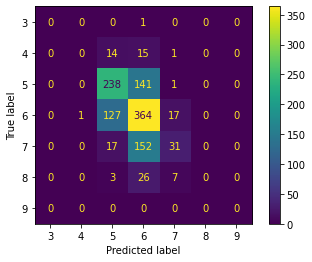

C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Logistic Regression:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.59      0.62      0.60       380
           6       0.53      0.70      0.60       509
           7       0.56      0.20      0.30       200
           8       1.00      0.00      0.00        36

    accuracy                           0.55      1156
   macro avg       0.61      0.25      0.25      1156
weighted avg       0.55      0.55      0.52      1156

training accuracy: 55.161220515040036
testing accuracy: 54.75778546712803

Confusion Matrix


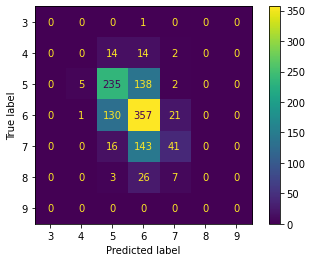

In [52]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_predict=logreg.predict(X_test)

print("\nLogistic Regression:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = logreg.score(X_train,y_train)
testing_accuracy = logreg.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logreg.classes_), display_labels=logreg.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

logregTunnedParams = logreg.set_params(**grid_search_logreg.best_params_)
logregTunnedParams.fit(X_train, y_train)

y_predict=logregTunnedParams.predict(X_test)

print("\nLogistic Regression:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = logregTunnedParams.score(X_train,y_train)
testing_accuracy = logregTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=logregTunnedParams.classes_), display_labels=logregTunnedParams.classes_).plot()  
plt.show()

## Perceptró

Per al grid search de la regressió lógistica mirarem els següents paràmetres:
- **Penalty**: Penalització per augmentar la magnitud dels valors dels paràmetres per reduir l'overfitting
    - 'l2': Penalització l2
    - 'l1': Penalització l1
- **Alpha**: Constant que multiplica el terme de regularització, si s'empra la regularització
- **max_iter**: Nombre màxim d'iteracions que triga el solucionador en convergir
- **early_stopping**: Si està establit a True atura l'entrenament quan el validation score deixa de millorar

In [53]:
param_grid = {
    'penalty': ['l2', 'l1', 'elasticnet', None],
    'alpha': [0.0001, 0.001, 0.01],
    'max_iter': [75,100,1000,2500,5000],
    'early_stopping': [True, False],
}
# Create a based model
perceptro = Perceptron()
# Instantiate the grid search model
grid_search_Perc = GridSearchCV(estimator = perceptro, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search_Perc.fit(X_train, y_train)

print(grid_search_Perc.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
{'alpha': 0.01, 'early_stopping': True, 'max_iter': 100, 'penalty': 'l1'}


\PERCEPTRON ABANS DEL GREEDSEARCH:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00        30
           5       0.48      0.88      0.62       380
           6       0.63      0.08      0.14       509
           7       0.32      0.09      0.13       200
           8       0.08      0.69      0.14        36

    accuracy                           0.36      1156
   macro avg       0.25      0.29      0.17      1156
weighted avg       0.50      0.36      0.29      1156

training accuracy: 35.59835533434322
testing accuracy: 35.89965397923876

Confusion Matrix


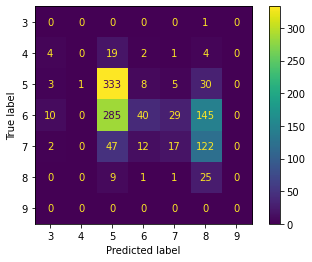

\PERCEPTRON DESPRÉS DEL GRIDSEARCH:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.00      0.00        30
           5       0.47      0.85      0.60       380
           6       0.53      0.38      0.44       509
           7       0.47      0.24      0.32       200
           8       1.00      0.00      0.00        36

    accuracy                           0.49      1156
   macro avg       0.74      0.24      0.23      1156
weighted avg       0.53      0.49      0.45      1156

training accuracy: 49.36161004111664
testing accuracy: 48.702422145328725

Confusion Matrix


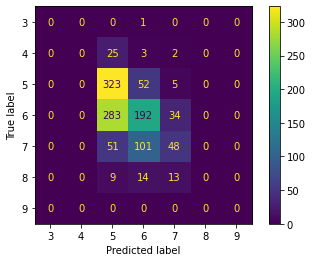

In [54]:
perc = Perceptron()
perc.fit(X_train, y_train)

y_predict=perc.predict(X_test)

print("PERCEPTRON ABANS DEL GRID SEARCH:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = perc.score(X_train,y_train)
testing_accuracy = perc.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=perc.classes_), display_labels=perc.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

percTunnedParams = perc.set_params(**grid_search_Perc.best_params_)
percTunnedParams.fit(X_train, y_train)

y_predict=percTunnedParams.predict(X_test)

print("PERCEPTRON DESPRÉS DEL GRIDSEARCH:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = percTunnedParams.score(X_train,y_train)
testing_accuracy = percTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=percTunnedParams.classes_), display_labels=percTunnedParams.classes_).plot()  
plt.show()

## Random Forest

Per al grid search del random forest mirarem els següents paràmetres:
- **max_depth**: Màxima profunditat d'un arbre
- **max_features**: Nombre de característiques a considerar quan cercam la millor divisió
    - 'auto': max_features=sqrt(n_features).
    - 'log2': max_features=log2(n_features).
    - 'None': max_features=n_features
- **n_estimators**: Nombre d'arbres en el bosc

In [62]:
param_grid={
    "n_estimators":list(range(10,101,10)),
    "max_features":['auto','log2',None],
    "max_depth":[15,20,25]
    }

# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10, n_jobs = -1)
grid_search_rf.fit(X_train, y_train)

print(grid_search_rf.best_params_)


C:\Users\walli\miniconda3\envs\ml-environment\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  warnings.warn(


{'max_depth': 20, 'max_features': 'auto', 'n_estimators': 70}



RANDOM FOREST ABANS DEL GREEDSEARCH:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       1.00      0.10      0.18        30
           5       0.71      0.75      0.73       380
           6       0.64      0.75      0.69       509
           7       0.74      0.54      0.62       200
           8       0.83      0.28      0.42        36

    accuracy                           0.68      1156
   macro avg       0.82      0.40      0.44      1156
weighted avg       0.70      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 68.16608996539793

Confusion Matrix


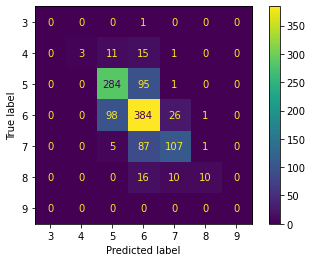


RANDOM FOREST DESPRÉS DEL GREEDSEARCH:
              precision    recall  f1-score   support

           3       1.00      0.00      0.00         1
           4       0.75      0.10      0.18        30
           5       0.70      0.74      0.72       380
           6       0.64      0.75      0.69       509
           7       0.76      0.55      0.63       200
           8       0.83      0.28      0.42        36

    accuracy                           0.68      1156
   macro avg       0.78      0.40      0.44      1156
weighted avg       0.69      0.68      0.67      1156

training accuracy: 100.0
testing accuracy: 67.99307958477509

Confusion Matrix


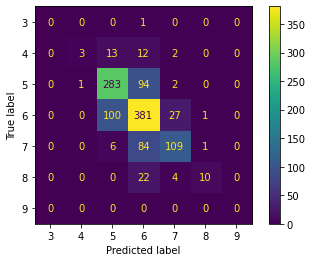

In [63]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict=rf.predict(X_test)

print("\nRANDOM FOREST ABANS DEL GREEDSEARCH:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = rf.score(X_train,y_train)
testing_accuracy = rf.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rf.classes_), display_labels=rf.classes_).plot()  
plt.show()

#---------------------------------------------------------------------------

rfTunnedParams = rf.set_params(**grid_search_rf.best_params_)
rfTunnedParams.fit(X_train, y_train)

y_predict=rfTunnedParams.predict(X_test)

print("\nRANDOM FOREST DESPRÉS DEL GREEDSEARCH:")
print(classification_report(y_test, y_predict,zero_division=1))

training_accuracy = rfTunnedParams.score(X_train,y_train)
testing_accuracy = rfTunnedParams.score(X_test,y_test)

print('training accuracy:', training_accuracy*100)    
print('testing accuracy:', testing_accuracy*100)

print("\nConfusion Matrix")
ConfusionMatrixDisplay(confusion_matrix(y_test,y_predict, labels=rfTunnedParams.classes_), display_labels=rfTunnedParams.classes_).plot()  
plt.show()


## Resum

Com podem veure el model amb millors resultats és el Random Forest, amb una precisió de XXXX, un recall de XXXX i un F1 score de XXXX. 
El Grid Search ha calculat que els millors paràmetres pel Random Forest son Max_depth: XXXX, Max_features: XXXX, min_samples_leaf: XXXX, min_samples_split: XXXX i n_estimators: XXXX. 

Amb aquests hyperparàmetres tenim una millora del XXXX% respecte al model amb els hyperparàmetres per defecte.

# **Conclusions i resum**